# Assignment 10

### 1.复习上课内容

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

>在贝叶斯公示$P(c|x)=\frac{P(c)P(x|c)}{P(x)}$中，估计后验概率$P(c|x)$的主要难点在于：类条件概率$P(x|c)$是所有属性上的联合概率，很难从有限的训练样本直接估计得到。而朴素贝叶斯(Naive bayes)采用了“属性条件独立性假设”：对已知类别，假设所有属性互相独立，也就是说$P(AB)=P(A)P(B)$。在这个假设下$P(x|c)=\prod_{i=1}^{d}P(x_i|c)$，而条件概率$P(x_i|c)$可以从样本中估计出来

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

>在给定数据D和假设空间H前提下，通过MAP或ML来对输入进行预测。
>MAP(maximum a posterior estimation), 即最大化后验概率。MAP最求的是在恒定的观测数据$D$下找出使后验概率$P(h|D)$最大的$h$。所以$P(D)$是恒定的，不影响优化结果
>$$h_{MAP} = {\arg\max}_h P(h|D) = {\arg\max}_h {\frac{P(D|h)P(h)}{P(D)}}={\arg\max}_h{P(D|h)P(h)}$$
>
>MLE，即最大似然估计。如果对于假设空间H中的所有假设h，概率相同，我们就得到了MLE模型。$$h_{ML} = {\arg\max}_h{P(D|h)}$$
>
>MLE提供了一种给定观察数据来评估模型参数的方法，即“模型已定，参数位置”，求使模型最优时的参数
>
>MAP和MLE类似，但是最大的区别在于，MLE假定模型参数本身的概率(即先验概率)是均匀的，而MAP需要考虑模型参数本身的概率分布。

#### 3. What is support vector in SVM?

>支持向量(support vector)指对分割超平面有贡献的样本点。因为分割超平面是由落在分割边界上的点来决定的，其他点不管有多少，都不影响分割超平面的位置，因此把那些支撑起分割超平面的样本点成为SVM中的支持向量


#### 4. What is the intuition behind SVM ?

>SVM利用直线（或高维空间中的超平面）对数据进行分类，使得离直线（或超平面）最近的点间隔最大化。
>
>比如在二维空间中有2类点，红点和蓝点，SVM就是找一个宽为d的直线把红点和蓝点分隔在两边，同时使d最大。

#### 5. Shortly describ what 'random' means in random forest ?

>随机森林中（Random Forest）中的随机：
>* 随机取样本组成样本集合；
>* 随机选择特征进行节点分裂

#### 6. What cariterion does XGBoost use to find the best split point in a tree ?

>XGBoost里的分裂准则是直接和损失函数挂钩的准则，根据这个准则，计算增益$Gain=\frac{1}{2}[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}]-\gamma$。其实就是让分裂后的增益减分裂钱的增益最大，或者说，选择让损失减少最多的分裂方法(增益越大，即损失函数越小)

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).

## 本次作业会使用VSM（vector space model）向量空间模型  和  Doc2Vec模型 

## 1. VSM（vector space model）向量空间模型

>假设每一个词是是文本向量的一个维度，一个文档看做一个词袋（词在文本中出现的顺序被忽略掉），去掉一些没有意义的停用词（如的、地这样的虚词），考虑一个词出现的次数和重要性就是TF/IDF，TF是文档中词出现的频率，出现次数越多越重要，IDF是逆文档频率，一个词出现在越多的文档中，越不重要。这样得到的词向量维度可能很高，根据具体的任务，如文本分类，可以通过词对于类别的信息增益或卡方检验来计算该词的重要性，截取top的词构建向量空间。

>缺点：忽略了词的顺序，损失了信息；词之间独立，近义词之间无法比较。

>优点：轻松处理长文本。

In [1]:
import pandas as pd
import numpy as np
import re
import jieba
from sklearn.model_selection import train_test_split                #划分训练/测试集
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import xgboost as xgb    
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve,auc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [2]:
# 获取中文停顿词函数
def getStopwords():
    stopwords = [line.strip() for line in open('chinese_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

In [3]:
# 获取中文停顿词
stopwords = getStopwords()

In [4]:
# 读取新闻数据函数
def read_news_data():
    # 用pd.read_csv方法读取新闻语料
    news = pd.read_csv('新华社数据.csv',engine='python')
    news = news.loc[:, ['source', 'title', 'content']]
    # 设置标签
    news.loc[news['source'] != '新华社', 'source'] = 0
    news.loc[news['source'] == '新华社', 'source'] = 1

    X = news['title'] +  news['content']
    y = news['source']
    return X, y

In [5]:
# 读取新闻数据
X, y = read_news_data()

In [6]:
# 中文分词函数，用正则去除多余的符号
def cut_text(text):
    text = str(text)
    text = re.sub('\\\\n|[\n\u3000\r]', ' ', text)
    relu = '！？｡。，＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀\
    ｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–\
    —‘\'‛“”„‟…‧﹏' + '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~·ʔ•'
    text = re.sub('[{}]'.format(relu), ' ', text)
    seg_list = jieba.cut(text)            
    sentence_segment=[] 
    for word in seg_list:
        if word not in stopwords:
            sentence_segment.append(word.strip())
    sentence_segment.append(word)        
    # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
    seg_res = ' '.join(sentence_segment)
    return seg_res

In [7]:
# 定义分类评估指标，actual为真实的类别，predict为预测的类别，predict_prod为预测类别的概率
def metrics_result(actual, predict, predict_prod):  
    precision_scores = precision_score(actual, predict,average='weighted')
    recall_scores = recall_score(actual, predict,average='weighted')
    f1_scores = f1_score(actual, predict,average='weighted')
    fpr, tpr, threshold = roc_curve(actual,predict_prod)
    auc_scores = auc(fpr, tpr)
    print('精度:{0:.3f}'.format(precision_scores))
    print('召回:{0:0.3f}'.format(recall_scores))  
    print('f1-score:{0:.3f}'.format(f1_scores))
    print('AUC:{0:.3f}'.format(auc_scores))
    return precision_scores, recall_scores, f1_scores, auc_scores

In [8]:
# 定义roc_curve_plot函数，用于绘制roc_curve图
def roc_curve_plot(y_test,y_pred):
    fpr, tpr, threshold = roc_curve(y_test,y_pred, pos_label=None, sample_weight=None,drop_intermediate=True)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(fpr, tpr)
    ax.plot([-0.005,1.01],[-0.005,1.01], ls='--')
    plt.xlim([-0.005,1.01])
    plt.ylim([-0.005,1.01])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show() 
    return fpr,tpr

In [7]:
# 运行分词函数（分词时间约12分钟）
%%time
new_X = X.apply(cut_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\shab\AppData\Local\Temp\jieba.cache


Wall time: 0 ns


Loading model cost 0.667 seconds.
Prefix dict has been built successfully.


In [8]:
# 保存分词结果
new_X.to_csv('new_X.csv')

In [9]:
# 读取分词csv文件
new_X = pd.read_csv('new_X.csv',index_col=0)

In [10]:
new_X.columns=['content']
new_X.head()

,content
0,小米 MIUI 首批 机型 曝光 共计 15 款 本周 月 12 日 小米 手机...
1,骁龙 835 Windows 10 性能 表现 有望 改善 骁龙 835 唯一 Windo...
2,一加 手机 细节 曝光 3300mAh 充 半小时 天 此前 一加 3T 搭载 3400...
3,葡 森林 火灾 至少 62 死亡 政府 紧急状态 组图 这是 月 18 日 葡萄牙 中...
4,44 岁 女子 约 网友 拒 暴雨 中 裸奔 交警 披衣 相随 原 标题 44 岁 女...


### 词袋向量化模型（TfidfVectorizer）

In [11]:
# TfidfVectorizer 是 CountVectorizer + TfidfTransformer的组合，输出的各个文本各个词的TF-IDF值
# min_df=5, max_features=10000
tfidf_vec = TfidfVectorizer(min_df=5, max_features=10000) 
tfidf_matrix = tfidf_vec.fit_transform(new_X['content'])

In [12]:
tfidf_matrix.shape

(89611, 10000)

In [13]:
tfidf_matrix

<89611x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4984293 stored elements in Compressed Sparse Row format>

In [14]:
y_c = y.values.astype(int)

In [15]:
# 划分数据集8:2，由于数据集不均衡，所以使用stratify=y_c，让划分的数据集比例保持原来的数据分布
X_train,X_test,y_train,y_test = train_test_split(tfidf_matrix, y_c, test_size = 0.2, random_state = 1,stratify = y_c)

### 支持向量机SVM（默认参数）

In [16]:
lsvc_c = LinearSVC()

In [17]:
lsvc_c.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [20]:
# lsvc_y_pred为预测类别，lsvc_y_prod为预测类别的概率
lsvc_y_pred = lsvc_c.predict(X_test)
lsvc_y_prod = lsvc_c.decision_function(X_test)

In [21]:
# 展示模型的各个评分
lsvc_ms = metrics_result(y_test, lsvc_y_pred, lsvc_y_prod)

精度:0.988
召回:0.988
f1-score:0.988
AUC:0.996


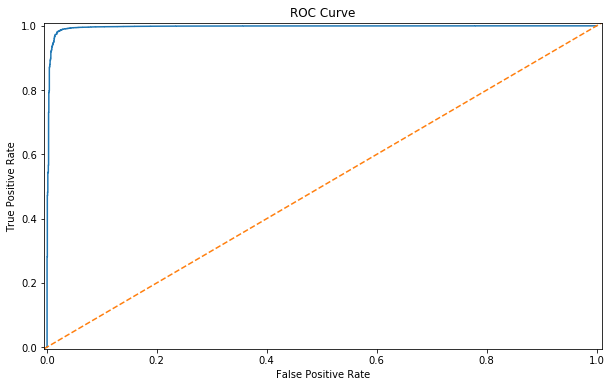

In [23]:
# 绘制roc_curve曲线
lsvc_fpr, lsvc_tpr = roc_curve_plot(y_test, lsvc_y_prod)

### 随机森林RandomForestClassifier（默认参数）

In [24]:
rfc_c = RandomForestClassifier(n_jobs=4,random_state=0)
rfc_c.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
rfc_y_pred = rfc_c.predict(X_test)
rfc_y_prob = rfc_c.predict_proba(X_test)[:,1]

In [26]:
rfc_ms = metrics_result(y_test, rfc_y_pred, rfc_y_prob)

精度:0.992
召回:0.992
f1-score:0.992
AUC:0.998


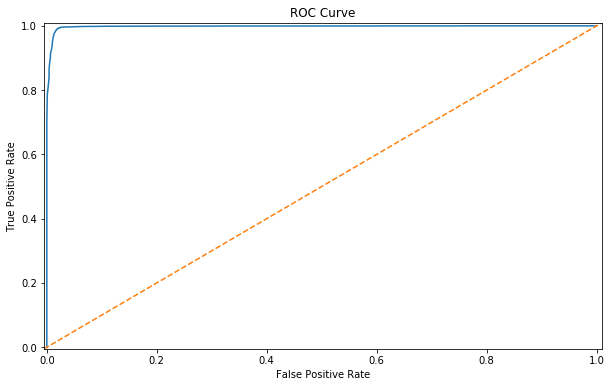

In [28]:
rfc_fpr, rfc_tpr = roc_curve_plot(y_test,rfc_y_prob)

### XGBOOST , sklearn接口，使用默认参数

In [30]:
xgb_c = XGBClassifier(n_estimatores=2000)

In [31]:
xgb_c.fit(X_train,
          y_train,
          eval_metric='auc',
          early_stopping_rounds=100,
          eval_set=[(X_train, y_train),(X_test, y_test)],
          verbose=100)

[0]	validation_0-auc:0.98279	validation_1-auc:0.98081
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.99996	validation_1-auc:0.99854


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimatores=2000, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [32]:
xgb_y_pred = xgb_c.predict(X_test)
xgb_y_prob = xgb_c.predict_proba(X_test)[:,1]

In [33]:
xgb_ms = metrics_result(y_test, xgb_y_pred, xgb_y_prob)

精度:0.993
召回:0.993
f1-score:0.993
AUC:0.999


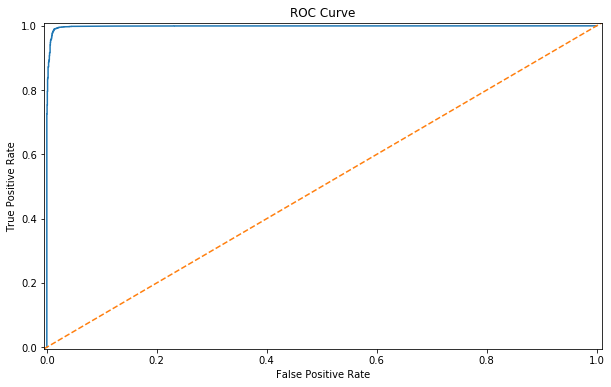

In [34]:

xgb_fpr, xgb_tpr = roc_curve_plot(y_test,xgb_y_prob)

### LightGBM , sklearn接口，使用默认参数

In [35]:
lgb_c = lgb.LGBMClassifier(n_estimators=2000,objective='binary')

In [36]:
lgb_c.fit(X_train,
          y_train, 
          eval_metric=['auc'], 
          early_stopping_rounds=100,
          eval_set=[(X_train, y_train),(X_test, y_test)],
          verbose=100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.999987	training's binary_logloss: 0.00621609	valid_1's auc: 0.998879	valid_1's binary_logloss: 0.0215143
[200]	training's auc: 1	training's binary_logloss: 0.00170186	valid_1's auc: 0.998918	valid_1's binary_logloss: 0.0219442
Early stopping, best iteration is:
[119]	training's auc: 0.999997	training's binary_logloss: 0.00469403	valid_1's auc: 0.998927	valid_1's binary_logloss: 0.021169


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
lgb_y_pred = lgb_c.predict(X_test)
lgb_y_prob = lgb_c.predict_proba(X_test)[:,1]

In [38]:
lgb_ms = metrics_result(y_test,lgb_y_pred,lgb_y_prob)

精度:0.994
召回:0.994
f1-score:0.994
AUC:0.999


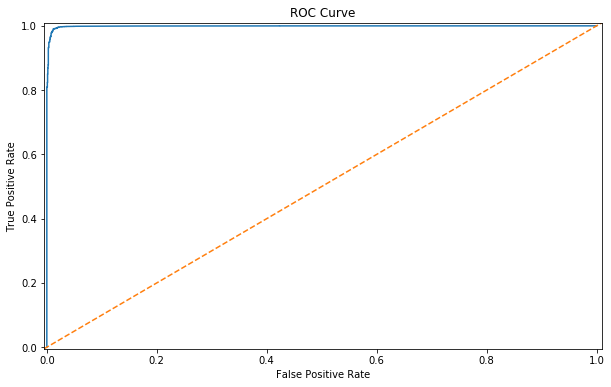

In [40]:
lgb_fpr, lgb_tpr = roc_curve_plot(y_test,lgb_y_prob)

### XGBOOST原生接口，使用贝叶斯调参

In [41]:
# 把数据转成原生接口的数据形式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test,label = y_test)

In [42]:
# 定义一个XGBOOST，为使用贝叶斯调参做准备
def XGB_CV(max_depth,
          gamma,
          eta,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree):
    # 定义接收的参数
    params = { 'booster' : 'gbtree',
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : True,
              'eval_metric': 'auc',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : eta,              
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 1001}

    # 在整个模型中使用了大约1000个助推轮
    cv_result = xgb.cv(params, 
                       dtrain,                     
                       num_boost_round = 20000,
                       #stratified = True,
                       nfold = 5,
                       #verbose_eval = 10,
                       early_stopping_rounds = 100,
                       metrics = 'auc',
                       show_stdv = True,
                       seed=0)    
    
    # 贝叶斯优化只知道如何最大化，而不是最小化，
    return max(cv_result['test-auc-mean'])

In [43]:
# 设定参数范围
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (6, 12),
                                     'gamma': (0.001, 10.0),
                                     'eta': (0.04, 0.3),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0)
                                    })

#### 调参也需要等待，等等等等等，计算15次大概用了2小时

In [44]:
# init_points为随机尝试次数，n_iter为优化尝试次数，次数越多，调参时间越长
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # 忽视一些警告，当然可以注释掉
    XGB_BO.maximize(init_points=5, n_iter=10, acq='ucb', xi=0.0,alpha=1e-6)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.998    |  0.8269   |  0.1365   |  9.787    |  0.7499   |  6.428    |  12.41    |  0.5488   |
|  2        |  0.9984   |  0.8631   |  0.2319   |  0.4945   |  9.119    |  6.031    |  7.265    |  0.5248   |
|  3        |  0.9985   |  0.5728   |  0.2502   |  0.3262   |  8.17     |  10.61    |  17.57    |  0.8909   |
|  4        |  0.9986   |  0.9824   |  0.08765  |  1.364    |  7.783    |  7.202    |  5.699    |  0.6633   |
|  5        |  0.9984   |  0.7427   |  0.1816   |  5.716    |  2.134    |  9.797    |  18.54    |  0.8788   |
|  6        |  0.9986   |  0.7514   |  0.1694   |  9.982    |  9.419    |  11.81    |  0.2628   |  0.8503   |
|  7        |  0.9987   |  0.7537   |  0.1536   |  0.5247   |  0.226    |  10.98    |  0.1961   |  0.5248   |
|  8      

In [56]:
# 显示最好的参数，当然你也可以查看XGB_BO的所有参数
XGB_BO.max['params']

{'colsample_bytree': 0.4016586273572678,
 'eta': 0.2528327126529844,
 'gamma': 0.24116608717075014,
 'max_delta_step': 0.1843254667183336,
 'max_depth': 10.19205147193765,
 'min_child_weight': 0.16488234226125442,
 'subsample': 0.8657608339656384}

In [57]:
# 把上面调参过程得到的最好参数拿来用
params = {
    'booster': 'gbtree',
    'objective' : 'binary:logistic',
    'nthread' : 4,
    'silent' : True,
    'eval_metric':'auc',
    'max_depth': int(XGB_BO.max['params']['max_depth']),
    'gamma' : XGB_BO.max['params']['gamma'],
    'gamma' : XGB_BO.max['params']['gamma'],
    'eta' : XGB_BO.max['params']['eta'],    
    'subsample' : XGB_BO.max['params']['subsample'],
    'colsample_bytree': XGB_BO.max['params']['colsample_bytree'],
    'min_child_weight' : XGB_BO.max['params']['min_child_weight'],
    'max_delta_step' : int(XGB_BO.max['params']['max_delta_step']),
    'verbose': 100,
    'seed' : 0
            }

In [58]:
# 显示训练过程中需要监控的数据
watchlist=[(dtrain,'train'),(dtest,'test')]
# 记录训练过程中监控的数据，需要定义一个空的dict
progress = dict()
# 用搜索得到的最佳参数训练新模型
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round = 5000,
                      early_stopping_rounds = 100,
                      evals = watchlist,
                      verbose_eval = 100,
                      evals_result = progress)

[0]	train-auc:0.93294	test-auc:0.92958
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[100]	train-auc:1.00000	test-auc:0.99899
[200]	train-auc:1.00000	test-auc:0.99892
Stopping. Best iteration:
[111]	train-auc:1.00000	test-auc:0.99900



In [59]:
# 显示best_iteration
xgb_model.best_iteration

111

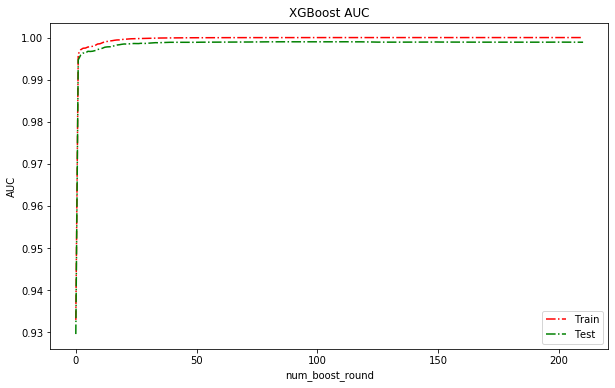

In [60]:
# 绘制在训练过程中的AUC变化
plt.figure(figsize=(10,6))
plt.plot(progress['train']['auc'],linestyle='-.',label='Train',color='r')
plt.plot(progress['test']['auc'],linestyle='-.',label='Test',color='g')
plt.xlabel('num_boost_round')
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.legend()
plt.show()

In [61]:
# 使用best_iteration来做预测
xgb_bay_y_pred = xgb_model.predict(dtest, ntree_limit = xgb_model.best_iteration)

In [62]:
# 由于预测值为0-1的浮点数，概率值，需要转成0或1
xgb_bay_predictions = [int(round(value)) for value in xgb_bay_y_pred]

In [63]:
xgb_bay_ms = metrics_result(y_test, xgb_bay_predictions, xgb_bay_y_pred)

精度:0.994
召回:0.994
f1-score:0.994
AUC:0.999


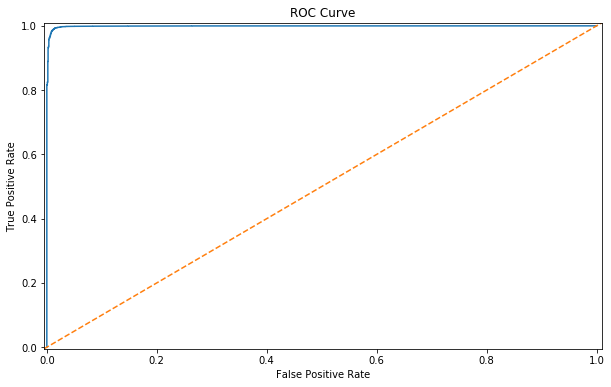

In [64]:
xgb_bay_fpr, xgb_bay_tpr = roc_curve_plot(y_test,xgb_bay_y_pred)

### LightGBM原生接口，使用贝叶斯调参

In [65]:
# 定义LightGBM调参函数
def LGB_CV(num_leaves, 
           learning_rate, 
           feature_fraction,
           lambda_l1, 
           lambda_l2, 
           max_depth, 
           bagging_fraction, 
           bagging_freq):
    
    # LightGBM希望接下来的三个参数是整数。所以我们把它们设为整数
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    bagging_freq = int(bagging_freq)
    
    assert type(num_leaves) == int
    assert type(max_depth) == int
    assert type(bagging_freq) == int
    # 定义接收的参数
    param = {
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False }    
        
    xg_train = lgb.Dataset(X_train, label=y_train)
    xg_valid = lgb.Dataset(X_test, label=y_test)   

    num_round = 10000    
    lgb_cv_result = lgb.cv(param,
                       xg_train, 
                       num_round,
                       nfold = 5,
                       stratified=False,
                       metrics='auc',
                       early_stopping_rounds=100,
                       seed=0
                              )
    
    return max(lgb_cv_result['auc-mean'])

In [66]:
#参数范围设定
bounds_LGB = {
    'num_leaves': (20, 50), 
    'learning_rate': (0.005, 0.1),   
    'feature_fraction': (0.1, 1),
    'lambda_l1': (0, 10.0), 
    'lambda_l2': (0, 10.0), 
    'max_depth':(3,15),
    'bagging_fraction':(0.2,1),
    'bagging_freq':(1,10),
}

#优化器
LGB_BO = BayesianOptimization(LGB_CV, bounds_LGB, random_state=13)

# 初始随机尝试
init_points = 2 
# 优化尝试
n_iter = 2     

with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # 忽视一些警告，当然可以注释掉
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)


|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9989   |  0.8222   |  3.138    |  0.8419   |  9.657    |  9.726    |  0.04808  |  10.31    |  43.27    |
|  2        |  0.9991   |  0.7133   |  7.498    |  0.1315   |  2.984    |  0.5851   |  0.08642  |  7.474    |  40.4     |
|  3        |  0.999    |  0.9063   |  8.964    |  0.5938   |  0.02646  |  0.1534   |  0.03167  |  4.003    |  20.2     |
|  4        |  0.9988   |  0.3789   |  1.153    |  0.6671   |  6.707    |  9.639    |  0.039    |  13.89    |  20.07    |


In [67]:
LGB_BO.max

{'target': 0.9990981624429001,
 'params': {'bagging_fraction': 0.7132906758072555,
  'bagging_freq': 7.498164065652524,
  'feature_fraction': 0.1315328716912936,
  'lambda_l1': 2.984494708891794,
  'lambda_l2': 0.5851249188207475,
  'learning_rate': 0.0864207895457839,
  'max_depth': 7.474248334497689,
  'num_leaves': 40.395438547342906}}

In [68]:
params = {
    'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
    'learning_rate': LGB_BO.max['params']['learning_rate'],   
    'feature_fraction': LGB_BO.max['params']['feature_fraction'],
    'lambda_l1': LGB_BO.max['params']['lambda_l1'], 
    'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
    'max_depth':int(LGB_BO.max['params']['max_depth']),
    'bagging_fraction':LGB_BO.max['params']['bagging_fraction'],
    'bagging_freq':int(LGB_BO.max['params']['bagging_freq']),
    'save_binary': True, 
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': False 
}

In [69]:
lgb_dtrain = lgb.Dataset(X_train, y_train)
lgb_dtest = lgb.Dataset(X_test, y_test,reference=lgb_dtrain)
# 显示训练过程中需要监控的数据
#lgb_watchlist=[(lgb_dtrain,'train'),(lgb_dtest,'test')]
lgb_watchlist=[lgb_dtest,lgb_dtrain]
# 记录训练过程中监控的数据，需要定义一个空的dict
lgb_progress = dict()
# 用搜索得到的最佳参数训练新模型
lgb_model = lgb.train(params, 
                      lgb_dtrain, 
                      num_boost_round = 5000,
                      early_stopping_rounds = 100,
                      valid_sets = [lgb_dtest,lgb_dtrain],
                      valid_names=['test', 'train'],
                      #eval_metric = 'auc',
                      evals_result =lgb_progress ,
                      verbose_eval = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.999056	test's auc: 0.998186
[200]	train's auc: 0.999644	test's auc: 0.998769
[300]	train's auc: 0.999808	test's auc: 0.998975
[400]	train's auc: 0.999888	test's auc: 0.999018
[500]	train's auc: 0.999922	test's auc: 0.999024
[600]	train's auc: 0.999946	test's auc: 0.999029
Early stopping, best iteration is:
[558]	train's auc: 0.999939	test's auc: 0.999052


In [70]:
# 使用best_iteration来做预测
lgb_bay_y_pred = lgb_model.predict(X_test, ntree_limit = lgb_model.best_iteration)

In [71]:
# 由于预测值为0-1的浮点数，概率值，需要转成0或1
lgb_bay_predictions = [int(round(value)) for value in lgb_bay_y_pred]

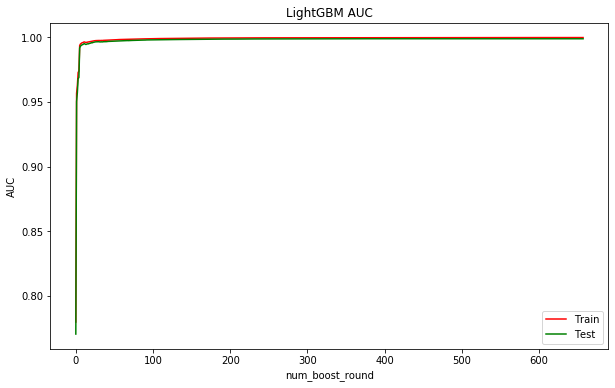

In [72]:
# 绘制在训练过程中的AUC变化
plt.figure(figsize=(10,6))
plt.plot(lgb_progress['train']['auc'],label='Train',color='r')
plt.plot(lgb_progress['test']['auc'],label='Test',color='g')
plt.xlabel('num_boost_round')
plt.ylabel('AUC')
plt.title('LightGBM AUC')
plt.legend()
plt.show()

In [73]:
lgb_bay_ms = metrics_result(y_test, lgb_bay_predictions, lgb_bay_y_pred)

精度:0.993
召回:0.993
f1-score:0.993
AUC:0.999


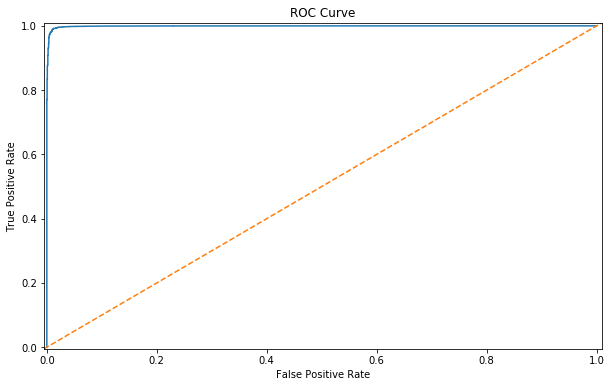

In [74]:
lgb_bay_fpr, lgb_bay_tpr = roc_curve_plot(y_test, lgb_bay_y_pred)

### 基于VSM，把所用到的机器学习模型的roc_curve放在一起对比一下

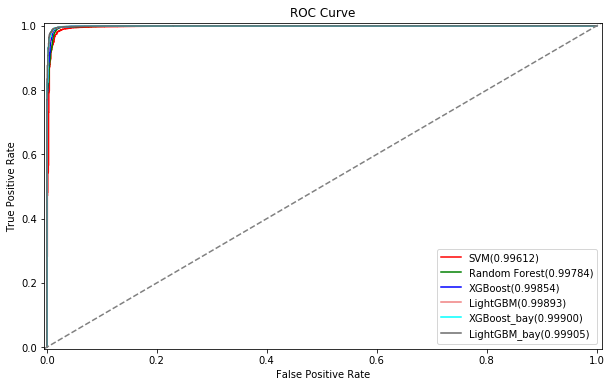

In [75]:
# 定义roc_curve_plot函数，用于绘制roc_curve图
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lsvc_fpr, lsvc_tpr, color='red', label='SVM({:.5f})'.format(auc(lsvc_fpr, lsvc_tpr)))
ax.plot(rfc_fpr, rfc_tpr, color='green', label='Random Forest({:.5f})'.format(auc(rfc_fpr, rfc_tpr)))
ax.plot(xgb_fpr, xgb_tpr, color='blue', label='XGBoost({:.5f})'.format(auc(xgb_fpr, xgb_tpr)))
ax.plot(lgb_fpr, lgb_tpr, color='lightcoral', label='LightGBM({:.5f})'.format(auc(lgb_fpr, lgb_tpr)))
ax.plot(xgb_bay_fpr, xgb_bay_tpr, color='aqua', label='XGBoost_bay({:.5f})'.format(auc(xgb_bay_fpr, xgb_bay_tpr)))
ax.plot(lgb_bay_fpr, lgb_bay_tpr, color='dimgray', label='LightGBM_bay({:.5f})'.format(auc(lgb_bay_fpr, lgb_bay_tpr)))
ax.plot([-0.005,1.01],[-0.005,1.01], ls='--',color='gray')
plt.xlim([-0.005,1.01])
plt.ylim([-0.005,1.01])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### ----------------------------------------------------------------分割线----------------------------------------------------------------------

## 2. Doc2Vec模型

>Doc2Vec 或者叫做 paragraph2vec, sentence embeddings，是一种非监督式算法，可以获得 sentences/paragraphs/documents 的向量表达，是 word2vec 的拓展。学出来的向量可以通过计算距离来找 sentences/paragraphs/documents 之间的相似性，可以用于文本聚类，对于有标签的数据，还可以用监督学习的方法进行文本分类，例如经典的情感分析问题。

>优点：1. Context层面保留词语顺序关系(PV-DM)；2. 具有语义

In [16]:
import jieba
import re
import numpy as np
import pandas as pd
import gensim
from gensim.models import doc2vec
import time
import gc
import os, sys
import logging
import multiprocessing
from optparse import OptionParser
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedLineDocument

In [17]:
# 读取分词csv文件
new_X_d2v = pd.read_csv('new_X.csv',index_col=0)

In [18]:
new_X_d2v.columns=['content']
new_X_d2v.head()

,content
0,小米 MIUI 首批 机型 曝光 共计 15 款 本周 月 12 日 小米 手机...
1,骁龙 835 Windows 10 性能 表现 有望 改善 骁龙 835 唯一 Windo...
2,一加 手机 细节 曝光 3300mAh 充 半小时 天 此前 一加 3T 搭载 3400...
3,葡 森林 火灾 至少 62 死亡 政府 紧急状态 组图 这是 月 18 日 葡萄牙 中...
4,44 岁 女子 约 网友 拒 暴雨 中 裸奔 交警 披衣 相随 原 标题 44 岁 女...


In [79]:
# doc2vec训练模型函数
def doc2vec_train(infile, size, window, min_count):
    '''train the doc vectors by doc2vec'''
    data = TaggedLineDocument(infile)
    model = doc2vec.Doc2Vec(data, vector_size = size, window = window, min_count = min_count, sample=1e-3, negative=5, workers=4)
    model.train(data, total_examples=model.corpus_count, epochs=10)
    # 保存模型
    model.save('doc2vec_model')
    return model
       
if __name__ == '__main__':
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger()  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running')    
    # 运行程序主函数
    doc2vec_train(infile = 'new_X_d2v.txt',size = 200, window = 3, min_count = 1)

2020-03-31 19:13:59,308 - INFO - running
2020-03-31 19:13:59,309 - INFO - collecting all words and their counts
2020-03-31 19:13:59,311 - INFO - PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-03-31 19:13:59,911 - INFO - PROGRESS: at example #10000, processed 2535726 words (4225431/s), 139133 word types, 10000 tags
2020-03-31 19:14:00,216 - INFO - PROGRESS: at example #20000, processed 3746151 words (3968008/s), 162127 word types, 20000 tags
2020-03-31 19:14:00,522 - INFO - PROGRESS: at example #30000, processed 4927222 words (3869467/s), 175715 word types, 30000 tags
2020-03-31 19:14:00,830 - INFO - PROGRESS: at example #40000, processed 6161217 words (4029166/s), 190171 word types, 40000 tags
2020-03-31 19:14:01,162 - INFO - PROGRESS: at example #50000, processed 7505408 words (4049507/s), 204643 word types, 50000 tags
2020-03-31 19:14:01,521 - INFO - PROGRESS: at example #60000, processed 8878299 words (3834021/s), 217988 word types, 60000 tags
2020-03-31

In [19]:
# 加载保存的模型文件
doc2vec_model = Doc2Vec.load('doc2vec_model')

### 划分数据集

In [20]:
# 划分数据集8:2，由于数据集不均衡，所以使用stratify=y_c，让划分的数据集比例保持原来的数据分布
X_train_vec, X_test_vec ,y_train_vec, y_test_vec = train_test_split(new_X_d2v['content'], y_c,test_size = 0.2,random_state = 1,stratify=y_c)

In [21]:
%%time
# 把训练集转成向量
X_train_vectors = [doc2vec_model.infer_vector(x.split(' ')) for x in X_train_vec]

Wall time: 3min 37s


In [22]:
X_train_vectors = np.array(X_train_vectors)

In [23]:
%%time
# 把测试集转成向量
X_test_vectors = [doc2vec_model.infer_vector(x.split(' ')) for x in X_test_vec]

Wall time: 54.4 s


In [24]:
X_test_vectors = np.array(X_test_vectors)

### 支持向量机SVM（默认参数）

In [58]:
lsvc_vec = LinearSVC()
lsvc_vec.fit(X_train_vectors, y_train_vec)

D:\Users\Jerry\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [59]:
lsvc_vec_y_pred = lsvc_vec.predict(X_test_vectors)
lsvc_vec_y_prod = lsvc_vec.decision_function(X_test_vectors)

In [60]:
lsvc_vec_ms = metrics_result(y_test_vec, lsvc_vec_y_pred, lsvc_vec_y_prod)

精度:0.894
召回:0.904
f1-score:0.883
AUC:0.863


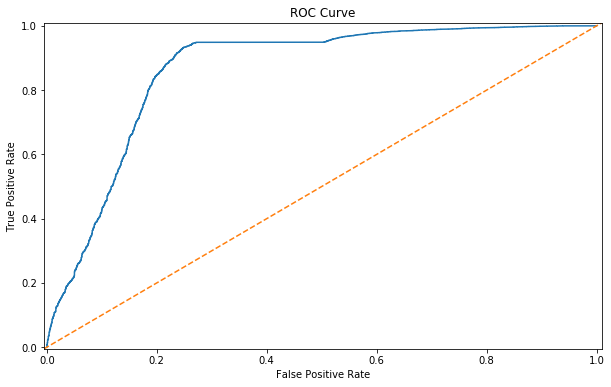

In [61]:
lsvc_vec_fpr, lsvc_vec_tpr = roc_curve_plot(y_test_vec,lsvc_vec_y_prod)

### 随机森林RandomForestClassifier（默认参数）

In [62]:
rfc_vec = RandomForestClassifier(n_jobs=4,random_state=0)
rfc_vec.fit(X_train_vectors, y_train_vec)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [63]:
rfc_vec_y_pred = rfc_vec.predict(X_test_vectors)
rfc_vec_y_prob = rfc_vec.predict_proba(X_test_vectors)[:,1]

In [64]:
rfc_vec_ms = metrics_result(y_test_vec, rfc_vec_y_pred, rfc_vec_y_prob)

精度:0.930
召回:0.930
f1-score:0.920
AUC:0.943


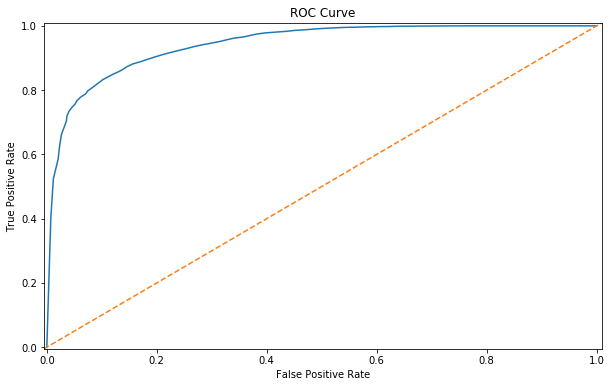

In [65]:
rfc_vec_fpr, rfc_vec_tpr = roc_curve_plot(y_test_vec, rfc_vec_y_prob)

### XGBOOST , sklearn接口，使用默认参数

In [66]:
xgb_vec = XGBClassifier(n_estimatores=2000)

In [67]:
xgb_vec.fit(X_train_vectors, 
            y_train_vec,
            eval_metric='auc',
            early_stopping_rounds=100,
            eval_set=[(X_train_vectors, y_train_vec),(X_test_vectors, y_test_vec)],
            verbose=100)
xgb_vec.score(X_test_vectors, y_test_vec)

[0]	validation_0-auc:0.89645	validation_1-auc:0.88630
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.99951	validation_1-auc:0.96878


0.9440941806617196

In [68]:
xgb_vec_y_pred = xgb_vec.predict(X_test_vectors)

In [69]:
xgb_vec_y_prod = xgb_vec.predict_proba(X_test_vectors)[:,-1]

In [70]:
metrics_result(y_test_vec, xgb_vec_y_pred, xgb_vec_y_prod)

精度:0.941
召回:0.944
f1-score:0.941
AUC:0.969


(0.9412433263393044,
 0.9440941806617196,
 0.9409146779030276,
 0.9688318942211163)

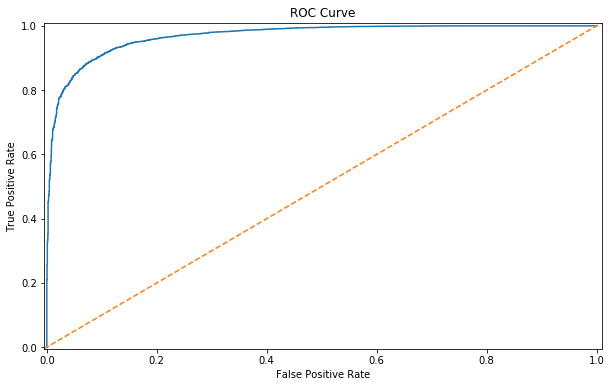

In [71]:
xgb_vec_fpr, xgb_vec_tpr = roc_curve_plot(y_test_vec, xgb_vec_y_prod)

### LightGBM , sklearn接口，使用默认参数

In [72]:
lgb_vec = lgb.LGBMClassifier(n_estimators=2000,objective='binary')

In [73]:
lgb_vec.fit(X_train_vectors, 
            y_train_vec,
            eval_metric='auc',
            early_stopping_rounds=100,
            eval_set=[(X_train_vectors, y_train_vec),(X_test_vectors, y_test_vec)],
            verbose=100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.987647	training's binary_logloss: 0.103406	valid_1's auc: 0.960554	valid_1's binary_logloss: 0.150552
[200]	training's auc: 0.99712	training's binary_logloss: 0.0664036	valid_1's auc: 0.967512	valid_1's binary_logloss: 0.13716
[300]	training's auc: 0.999472	training's binary_logloss: 0.0457303	valid_1's auc: 0.970153	valid_1's binary_logloss: 0.132358
[400]	training's auc: 0.999967	training's binary_logloss: 0.0319544	valid_1's auc: 0.971729	valid_1's binary_logloss: 0.129916
[500]	training's auc: 0.999999	training's binary_logloss: 0.022534	valid_1's auc: 0.972702	valid_1's binary_logloss: 0.129387
Early stopping, best iteration is:
[464]	training's auc: 0.999996	training's binary_logloss: 0.0257833	valid_1's auc: 0.972447	valid_1's binary_logloss: 0.129174


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
lgb_vec_y_pred = lgb_vec.predict(X_test_vectors)
lgb_vec_y_prob = lgb_vec.predict_proba(X_test_vectors)[:,1]

In [75]:
lgb_vec_ms = metrics_result(y_test_vec, lgb_vec_y_pred, lgb_vec_y_prob)

精度:0.945
召回:0.948
f1-score:0.944
AUC:0.972


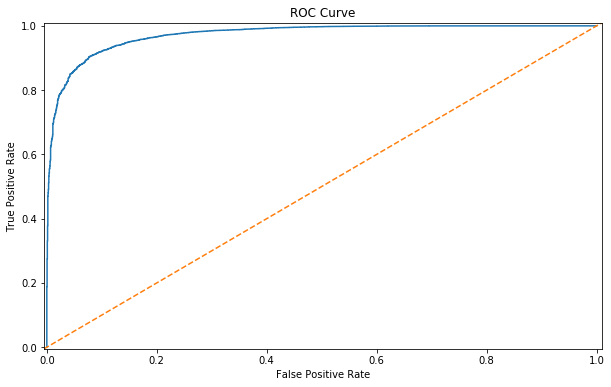

In [76]:
lgb_vec_fpr, lgb_vec_tpr = roc_curve_plot(y_test_vec,lgb_vec_y_prob)

### XGBOOST原生接口，使用贝叶斯调参

In [25]:
# 把数据转成原生接口的数据形式
dtrain = xgb.DMatrix(X_train_vectors, label=y_train_vec)
dtest = xgb.DMatrix(X_test_vectors,label = y_test_vec)

In [32]:
# 定义一个XGBOOST，为使用贝叶斯调参做准备
def XGB_CV(max_depth,
          gamma,
          eta,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree):
    # 定义接收的参数
    params = { 'booster' : 'gbtree',
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : True,
              'eval_metric': 'auc',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : eta,              
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 1001}

    # 在整个模型中使用了大约1000个助推轮
    cv_result = xgb.cv(params, 
                       dtrain,                     
                       num_boost_round = 20000,
                       #stratified = True,
                       nfold = 3,
                       verbose_eval = 100,
                       early_stopping_rounds = 50,
                       metrics = 'auc',
                       show_stdv = True,
                       seed=0)    
    
    # 贝叶斯优化只知道如何最大化，而不是最小化，
    return max(cv_result['test-auc-mean'])

In [33]:
# 设定参数范围
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (6, 12),
                                     'gamma': (0.001, 10.0),
                                     'eta': (0.04, 0.3),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0)
                                    })

### 由于调参时间过长，所以这里只调4次参数

In [34]:
%%time
# init_points为随机尝试次数，n_iter为优化尝试次数，次数越多，调参时间越长
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # 忽视一些警告，当然可以注释掉
    XGB_BO.maximize(init_points=2, n_iter=2, acq='ucb', xi=0.0,alpha=1e-6)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.92357+0.00312	test-auc:0.89391+0.00264
[100]	train-auc:1.00000+0.00000	test-auc:0.96596+0.00057
[200]	train-auc:1.00000+0.00000	test-auc:0.96788+0.00073
[300]	train-auc:1.00000+0.00000	test-auc:0.96844+0.00066
[400]	train-auc:1.00000+0.00000	test-auc:0.96865+0.00063
[500]	train-auc:1.00000+0.00000	test-auc:0.96874+0.00060
[600]	train-auc:1.00000+0.00000	test-auc:0.96881+0.00068
[700]	train-auc:1.00000+0.00000	test-auc:0.96887+0.00064
[800]	train-auc:1.00000+0.00000	test-auc:0.96891+0.00060
[900]	train-auc:1.00000+0.00000	test-auc:0.96896+0.00057
[1000]	train-auc:1.00000+0.00000	test-auc:0.96903+0.00060
|  1        |  0.9691   |  0.7638   |  0.2166   |  1.748    |  7.189    |  11.64    |  6.942    |  0.7136   |
[0]	train-auc:0.90760+0.00101	test-auc:0.882

In [35]:
# 显示最好的参数，当然你也可以查看XGB_BO的所有参数
XGB_BO.max['params']

{'colsample_bytree': 0.6188214895961991,
 'eta': 0.04941666755125003,
 'gamma': 0.11127192776979741,
 'max_delta_step': 9.848335430625735,
 'max_depth': 7.349595691259216,
 'min_child_weight': 19.282370863502962,
 'subsample': 0.4554948522237676}

In [36]:
# 把上面调参过程得到的最好参数拿来用
params = {
    'booster': 'gbtree',
    'objective' : 'binary:logistic',
    'nthread' : 4,
    'silent' : True,
    'eval_metric':'auc',
    'max_depth': int(XGB_BO.max['params']['max_depth']),
    'gamma' : XGB_BO.max['params']['gamma'],
    'gamma' : XGB_BO.max['params']['gamma'],
    'eta' : XGB_BO.max['params']['eta'],    
    'subsample' : XGB_BO.max['params']['subsample'],
    'colsample_bytree': XGB_BO.max['params']['colsample_bytree'],
    'min_child_weight' : XGB_BO.max['params']['min_child_weight'],
    'max_delta_step' : int(XGB_BO.max['params']['max_delta_step']),
    'verbose': 100,
    'seed' : 0
            }

In [37]:
# 显示训练过程中需要监控的数据
watchlist=[(dtrain,'train'),(dtest,'test')]
# 记录训练过程中监控的数据，需要定义一个空的dict
progress = dict()
# 用搜索得到的最佳参数训练新模型
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round = 5000,
                      early_stopping_rounds = 100,
                      evals = watchlist,
                      verbose_eval = 100,
                      evals_result = progress)

[0]	train-auc:0.89881	test-auc:0.89154
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[100]	train-auc:0.97149	test-auc:0.95171
[200]	train-auc:0.98581	test-auc:0.96389
[300]	train-auc:0.99140	test-auc:0.96861
[400]	train-auc:0.99473	test-auc:0.97136
[500]	train-auc:0.99682	test-auc:0.97318
[600]	train-auc:0.99811	test-auc:0.97440
[700]	train-auc:0.99890	test-auc:0.97531
[800]	train-auc:0.99935	test-auc:0.97591
[900]	train-auc:0.99966	test-auc:0.97628
[1000]	train-auc:0.99981	test-auc:0.97667
[1100]	train-auc:0.99991	test-auc:0.97697
[1200]	train-auc:0.99996	test-auc:0.97735
[1300]	train-auc:0.99999	test-auc:0.97767
[1400]	train-auc:1.00000	test-auc:0.97782
[1500]	train-auc:1.00000	test-auc:0.97801
[1600]	train-auc:1.00000	test-auc:0.97812
[1700]	train-auc:1.00000	test-auc:0.97824
[1800]	train-auc:1.00000	test-auc:0.97830
[1900]	train-auc:1.00000	test-auc:0.97840
[2000]	train-auc:1.00000	test-

In [38]:
# 显示best_iteration
xgb_model.best_iteration

2673

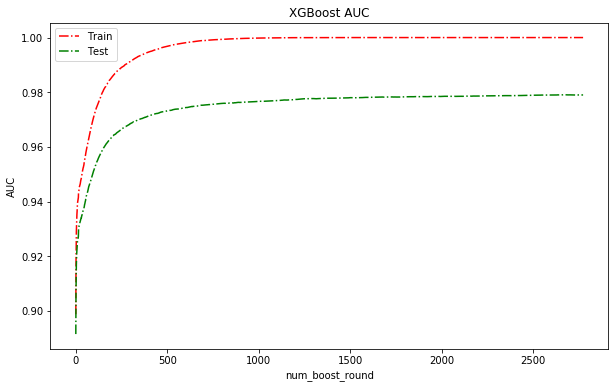

In [39]:
# 绘制在训练过程中的AUC变化
plt.figure(figsize=(10,6))
plt.plot(progress['train']['auc'],linestyle='-.',label='Train',color='r')
plt.plot(progress['test']['auc'],linestyle='-.',label='Test',color='g')
plt.xlabel('num_boost_round')
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.legend()
plt.show()

In [40]:
# 使用best_iteration来做预测
xgb_vec_bay_y_pred = xgb_model.predict(dtest, ntree_limit = xgb_model.best_iteration)

In [41]:
# 由于预测值为0-1的浮点数，概率值，需要转成0或1
xgb_vec_bay_predictions = [int(round(value)) for value in xgb_vec_bay_y_pred]

In [42]:
xgb_vec_bay_ms = metrics_result(y_test_vec, xgb_vec_bay_predictions, xgb_vec_bay_y_pred)

精度:0.952
召回:0.954
f1-score:0.952
AUC:0.979


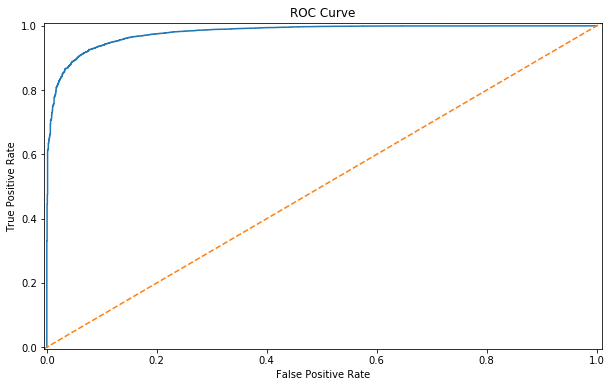

In [43]:
xgb_vec_bay_fpr, xgb_vec_bay_tpr = roc_curve_plot(y_test_vec ,xgb_vec_bay_y_pred)

### LightGBM原生接口，使用贝叶斯调参

In [44]:
# 把数据转成原生接口的数据形式
lgb_dtrain = lgb.Dataset(X_train_vectors, y_train_vec)
lgb_dtest = lgb.Dataset(X_test_vectors, y_test_vec, reference=lgb_dtrain)

In [45]:
# 定义LightGBM调参函数
def LGB_CV(num_leaves, learning_rate, feature_fraction,
                lambda_l1, lambda_l2, max_depth, bagging_fraction, bagging_freq):
    
    # LightGBM希望接下来的三个参数是整数。所以我们把它们设为整数
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    bagging_freq = int(bagging_freq)
    
    assert type(num_leaves) == int
    assert type(max_depth) == int
    assert type(bagging_freq) == int
    # 定义接收的参数
    param = {
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False }    
        
    xg_train = lgb_dtrain     #lgb.Dataset(X_train, label=y_train)
    xg_valid = lgb_dtest      #lgb.Dataset(X_test, label=y_test)   

    num_round = 10000    
    lgb_cv_result = lgb.cv(param,
                       xg_train, 
                       num_round,
                       nfold = 5,
                       stratified=False,
                       metrics='auc',
                       early_stopping_rounds=100,
                       seed=0
                              )
    
    return max(lgb_cv_result['auc-mean'])

In [46]:
#参数范围设定
bounds_LGB = {
    'num_leaves': (20, 50), 
    'learning_rate': (0.005, 0.1),   
    'feature_fraction': (0.1, 1),
    'lambda_l1': (0, 10.0), 
    'lambda_l2': (0, 10.0), 
    'max_depth':(3,15),
    'bagging_fraction':(0.2,1),
    'bagging_freq':(1,10),
}

#优化器
LGB_BO = BayesianOptimization(LGB_CV, bounds_LGB, random_state=13)

# 初始随机尝试
init_points = 1 
# 优化尝试
n_iter = 3    

with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # 忽视一些警告，当然可以注释掉
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)


|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.977    |  0.8222   |  3.138    |  0.8419   |  9.657    |  9.726    |  0.04808  |  10.31    |  43.27    |
|  2        |  0.9775   |  0.9769   |  3.779    |  0.9245   |  2.631    |  3.299    |  0.03831  |  5.202    |  29.5     |
|  3        |  0.9761   |  0.4855   |  9.714    |  0.7505   |  7.058    |  0.01647  |  0.06549  |  14.3     |  20.32    |
|  4        |  0.9728   |  0.6501   |  8.338    |  0.1118   |  1.836    |  9.788    |  0.09634  |  3.433    |  49.55    |


In [47]:
LGB_BO.max

{'target': 0.9775296097850908,
 'params': {'bagging_fraction': 0.976886840339686,
  'bagging_freq': 3.7794443034967404,
  'feature_fraction': 0.9244541780563676,
  'lambda_l1': 2.6305718118512567,
  'lambda_l2': 3.298969537381815,
  'learning_rate': 0.03830852803767568,
  'max_depth': 5.202204519504758,
  'num_leaves': 29.50015214170596}}

In [48]:
params = {
    'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
    'learning_rate': LGB_BO.max['params']['learning_rate'],   
    'feature_fraction': LGB_BO.max['params']['feature_fraction'],
    'lambda_l1': LGB_BO.max['params']['lambda_l1'], 
    'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
    'max_depth':int(LGB_BO.max['params']['max_depth']),
    'bagging_fraction':LGB_BO.max['params']['bagging_fraction'],
    'bagging_freq':int(LGB_BO.max['params']['bagging_freq']),
    'save_binary': True, 
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': False 
}

In [51]:
# 显示训练过程中需要监控的数据
#lgb_watchlist=[(lgb_dtrain,'train'),(lgb_dtest,'test')]
lgb_watchlist=[lgb_dtest,lgb_dtrain]
# 记录训练过程中监控的数据，需要定义一个空的dict
lgb_progress = dict()
# 用搜索得到的最佳参数训练新模型
lgb_model = lgb.train(params, 
                      lgb_dtrain, 
                      num_boost_round = 20000,
                      early_stopping_rounds = 100,
                      valid_sets = [lgb_dtest,lgb_dtrain],
                      valid_names=['test', 'train'],
                      evals_result =lgb_progress ,
                      verbose_eval = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.959359	test's auc: 0.944624
[200]	train's auc: 0.975431	test's auc: 0.956591
[300]	train's auc: 0.983703	test's auc: 0.962298
[400]	train's auc: 0.988882	test's auc: 0.965849
[500]	train's auc: 0.992207	test's auc: 0.968034
[600]	train's auc: 0.994578	test's auc: 0.969693
[700]	train's auc: 0.996193	test's auc: 0.971116
[800]	train's auc: 0.997339	test's auc: 0.972119
[900]	train's auc: 0.998163	test's auc: 0.973015
[1000]	train's auc: 0.998715	test's auc: 0.973692
[1100]	train's auc: 0.999136	test's auc: 0.97431
[1200]	train's auc: 0.999445	test's auc: 0.974779
[1300]	train's auc: 0.999651	test's auc: 0.975272
[1400]	train's auc: 0.999784	test's auc: 0.975735
[1500]	train's auc: 0.999869	test's auc: 0.976168
[1600]	train's auc: 0.999922	test's auc: 0.976544
[1700]	train's auc: 0.999956	test's auc: 0.976816
[1800]	train's auc: 0.999976	test's auc: 0.976979
[1900]	train's auc: 0.999989	test's auc: 0.97723

In [52]:
# 使用best_iteration来做预测
lgb_vec_bay_y_pred = lgb_model.predict(X_test_vectors, ntree_limit = lgb_model.best_iteration)

In [53]:
# 由于预测值为0-1的浮点数，概率值，需要转成0或1
lgb_vec_bay_predictions = [int(round(value)) for value in lgb_vec_bay_y_pred]

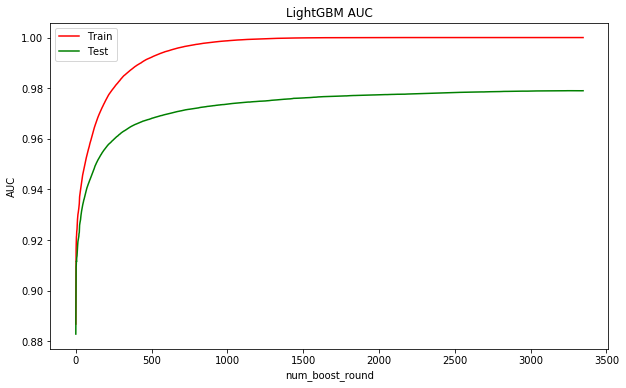

In [54]:
# 绘制在训练过程中的AUC变化
plt.figure(figsize=(10,6))
plt.plot(lgb_progress['train']['auc'],label='Train',color='r')
plt.plot(lgb_progress['test']['auc'],label='Test',color='g')
plt.xlabel('num_boost_round')
plt.ylabel('AUC')
plt.title('LightGBM AUC')
plt.legend()
plt.show()

In [55]:
lgb_vec_bay_ms = metrics_result(y_test_vec, lgb_vec_bay_predictions ,lgb_vec_bay_y_pred)

精度:0.954
召回:0.954
f1-score:0.954
AUC:0.979


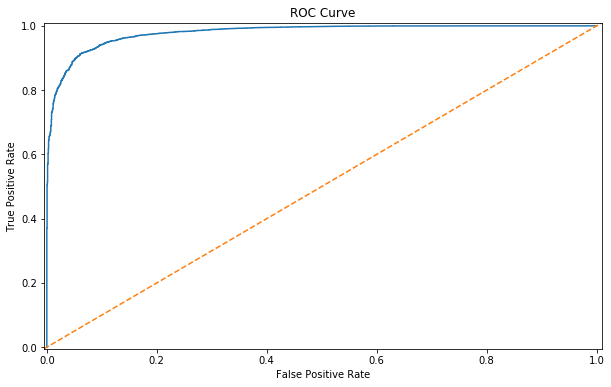

In [56]:
lgb_vec_bay_fpr, lgb_vec_bay_tpr = roc_curve_plot(y_test_vec,lgb_vec_bay_y_pred)

### 基于Doc2Vec ，把所用到的机器学习模型的roc_curve放在一起对比一下

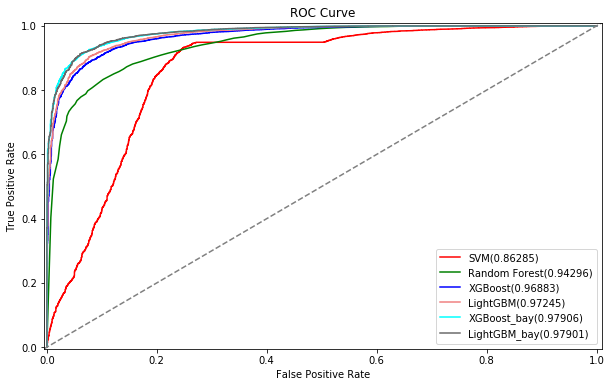

In [77]:
# 定义roc_curve_plot函数，用于绘制roc_curve图
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lsvc_vec_fpr, lsvc_vec_tpr, color='red', label='SVM({:.5f})'.format(auc(lsvc_vec_fpr, lsvc_vec_tpr)))
ax.plot(rfc_vec_fpr, rfc_vec_tpr, color='green', label='Random Forest({:.5f})'.format(auc(rfc_vec_fpr, rfc_vec_tpr)))
ax.plot(xgb_vec_fpr, xgb_vec_tpr, color='blue', label='XGBoost({:.5f})'.format(auc(xgb_vec_fpr, xgb_vec_tpr)))
ax.plot(lgb_vec_fpr, lgb_vec_tpr, color='lightcoral', label='LightGBM({:.5f})'.format(auc(lgb_vec_fpr, lgb_vec_tpr)))
ax.plot(xgb_vec_bay_fpr, xgb_vec_bay_tpr, color='aqua', label='XGBoost_bay({:.5f})'.format(auc(xgb_vec_bay_fpr, xgb_vec_bay_tpr)))
ax.plot(lgb_vec_bay_fpr, lgb_vec_bay_tpr, color='dimgray', label='LightGBM_bay({:.5f})'.format(auc(lgb_vec_bay_fpr, lgb_vec_bay_tpr)))
ax.plot([-0.005,1.01],[-0.005,1.01], ls='--',color='gray')
plt.xlim([-0.005,1.01])
plt.ylim([-0.005,1.01])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##  总结

 ### VSM（vector space model）向量空间模型 和   Doc2Vec模型
 >1. 使用了SVM、Random Forest、XGBoost、LightGBM这四种算法，其中XGBoost和LightGBM都使用了调参；
 >
 >2. 在VSM向量空间模型中的表现都非常不错，很容易就达到AUC 99%;而在Doc2Vec中，使用同样的参数，表现都不如VSM
 >
 >3. 在划分数据集的时候，由于正样本和负样本不均衡，所以采用了分层划分，划分后正负样本的比例跟原来的分布相同
 >
 >4. 在本数据集中，经过调参后的模型，提升不明显，但还是调参后的AUC最高
 >
 >>LightGBM_bay > XGBoost_bay > LightGBM > XGBoost > Random Forest > SVM
 >
 >5. 在四个算法当中，LightGBM的表现是最好的，无论是运算速度，内存占用，还是预测的结果
 >
 >6. 有条件的，还是使用GPU进行运算会好很多，XGBoost和LightGBM都支持GPU了